In [1]:
import pandas as pd
import geopandas as gpd
import os
import requests
import esda
import libpysal
import multiprocessing as mp
import itertools
import pygeos
import subprocess
import json
import sys
import shapely
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
output_path = './Multi_F_Results'

In [25]:
state_lookup = pd.read_csv('./census_geometry/state_lookup.csv')

mi = gpd.GeoDataFrame()
for i in range(0, 15):
    temp_path = os.path.join(output_path, f'N_{i}', f'Multi_F_mi.geojson')
    if os.path.exists(temp_path):
        temp_ = gpd.read_file(temp_path)
        temp_['iter'] = i
        mi = pd.concat([mi, temp_], ignore_index=True)

mi = mi.fillna(0)
mi['STATE'] = mi.apply(lambda x:x['ID'][0:2], axis=1)
mi = mi.merge(state_lookup, left_on='STATE', right_on='Abbr', how='left')

mi = mi.to_crs(epsg=5070)

mi.head()

,ID,LAT,LON,NAME,LIBRARY_ID,LIBRARY_TYPE,MH_F,IH_F,TAS_F,SS_F,...,pval_GROUPQ,dist_GROUPQ,geometry,iter,STATE,Name,Abbr,FIPS,ContiguousUS,Region
0,CA10114,36.416309,-119.003224,TERMINUS DAM,199,dam_study,True,False,True,True,...,1.477466e-01,25000,POINT (-2023906.324 1731514.024),0,CA,California,CA,6,1,Pacific
1,CA10113,36.060671,-118.919340,Richard L. Schafer Dam,98,dam_study,True,False,True,True,...,6.966340e-07,25000,POINT (-2026183.366 1691051.608),0,CA,California,CA,6,1,Pacific
2,NY00468,42.733294,-77.907232,MOUNT MORRIS DAM,316,dam_study,True,False,True,True,...,0.000000e+00,2500,POINT (1463933.450 2332679.707),0,NY,New York,NY,36,1,MiddleAtlantic
3,CA10109,38.151041,-120.813699,NEW HOGAN DAM,297,dam_study,True,False,True,True,...,1.231008e-03,25000,POINT (-2129517.012 1959358.301),0,CA,California,CA,6,1,Pacific
4,CA10104,37.906801,-120.934059,FARMINGTON DAM,260,dam_study,True,False,True,True,...,0.000000e+00,2500,POINT (-2146709.171 1935623.650),0,CA,California,CA,6,1,Pacific


In [20]:
states = gpd.read_file('./data_plot/tl_2022_us_state.shp')
states = states.loc[states['STUSPS'].isin(state_lookup.loc[state_lookup['ContiguousUS'] == 1, 'Abbr'].values)]
us_geom = states['geometry'].unary_union
states = states.to_crs(epsg=5070)

<Axes: >

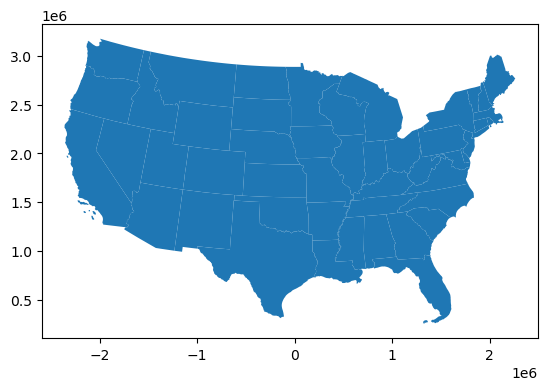

In [21]:
states.plot()

In [7]:
dams = pd.read_csv('./data_plot/nation.csv', header=1)
dams = gpd.GeoDataFrame(dams, geometry=gpd.points_from_xy(dams.Longitude, dams.Latitude, crs='EPSG:4326'))
dams = dams.reset_index(drop=True)
# dams_sc = dams.loc[dams['geometry'].intersects(county_dis['geometry'].values[0])]
print(dams.shape)
dams.head(1)

(92072, 76)


/var/folders/dv/bcrkszqj0634wz_17m9xw0qr0000gn/T/ipykernel_18260/316814696.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  dams = pd.read_csv('./data_plot/nation.csv', header=1)


,Dam Name,Other Names,Former Names,NID ID,Other Structure ID,Federal ID,Owner Names,Owner Types,Primary Owner Type,State or Federal Agency ID,...,Data Last Updated,Last Inspection Date,Inspection Frequency,Hazard Potential Classification,Condition Assessment,Condition Assessment Date,EAP Prepared,EAP Last Revision Date,Website URL,geometry
0,Dod Usa 2,NaN,Dod Usa,OK20994,NaN,OK20994,DEPT. OF DEFENSE/US ARMY RESERVE CENTER,Federal,Federal,NaN,...,2018-06-22,1998-10-01,5.0,Low,Not Rated,NaN,Not Required,NaN,https://damsafety.org/oklahoma,POINT (-95.13638 35.70341)


In [23]:
dams_us = dams.loc[dams['geometry'].intersects(us_geom)]
dams_us = dams_us.to_crs(epsg=5070)

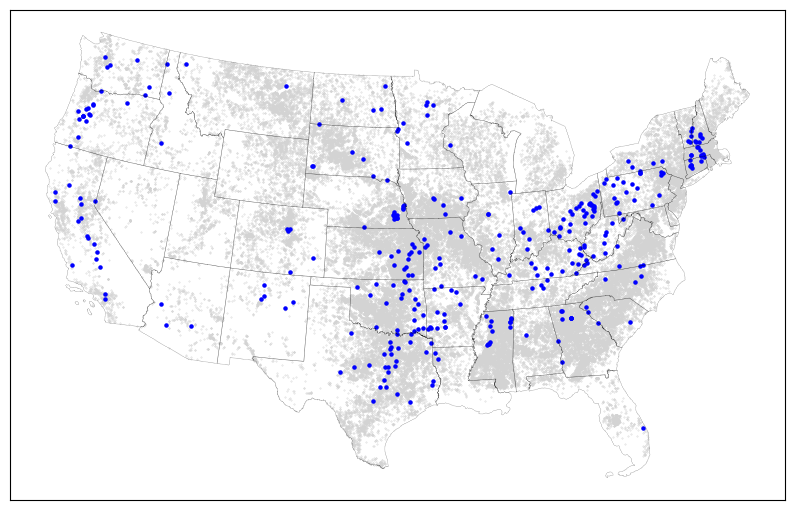

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))

dams_us.plot(ax=ax, color='lightgrey', markersize=0.1)
mi.plot(ax=ax, color='blue', markersize=5)
states.boundary.plot(ax=ax, linewidth=0.3, edgecolor='k', linestyle=':')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

## Plot three inundation maps for a single dam 

In [6]:
dam_id = 'TX00018'
iter_num = mi.loc[mi['ID'] == dam_id, 'iter'].values[0]
iter_num

13

In [7]:
fim = gpd.read_file(os.path.join(output_path, f'N_{iter_num}', f'Multi_F_fim.geojson'))
lm = gpd.read_file(os.path.join(output_path, f'N_{iter_num}', f'Multi_F_lm.geojson'))
fim = fim.loc[fim['Dam_ID'] == dam_id]
lm = lm.loc[lm['Dam_ID'] == dam_id]

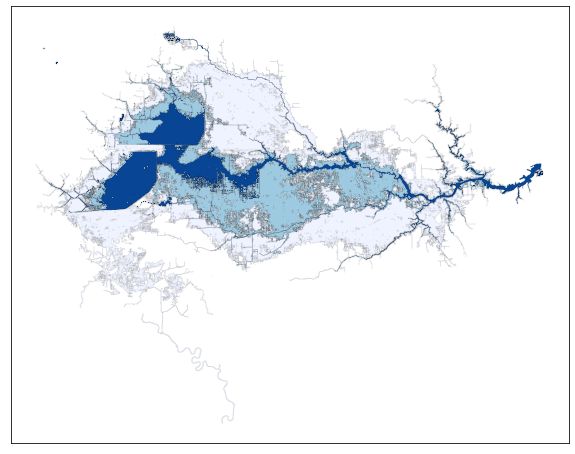

In [28]:
fig, ax = plt.subplots(figsize=(10,10))

color_brewer = ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#084594']
# color_brewer.reverse()
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=7)
fim = fim.to_crs(epsg=4326)

fim.plot('value', ax=ax, cmap=cm)
fim.boundary.plot(ax=ax, linewidth=0.05, color='black')
ax.get_xaxis().set_visible(False)  # Remove ticks and labels
ax.get_yaxis().set_visible(False)
plt.show()